# Loading Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Global Variable
dict_clean_img = {}

# Defining utilities functions

In [12]:
def sort_contours(cnts, method="left-to-right"):
    '''
    sort_contours : Function to sort contours
    argument:
        cnts (array): image contours
        method(string) : sorting direction
    output:
        cnts(list): sorted contours
        boundingBoxes(list): bounding boxes
    '''
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def extract_box(img, show=True):
    '''
    Function to extract the boxes in the ruled worksheet
    Input : Image with rectangle, show figures
    Output : Extract workspaces locations
    '''
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Otsu thresholding
    thresh, binary_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Defining a kernel length
    kernel_length = np.array(binary_image).shape[1]//80

    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Morphological operation to detect vertical lines from an image
    img_temp1 = cv2.erode(binary_image, verticle_kernel, iterations=3)
    verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)

    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(binary_image, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
    
    #Join horizontal and vertical images
    alpha = 0.5
    beta = 1.0 - alpha
    img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(img_final_bin, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    #Find and sort the contours
    contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    (contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")
    
    area = []
    for contour in contours:
        area.append(cv2.contourArea(contour))
    
    s = np.argsort(area) #sorted area
    
    workspace_contours = []    
    #Find the correct boxes where area is between 40% and 50% of the largest rectangle
    for i,contour in enumerate(contours):
        if cv2.contourArea(contour) >= area[s[-1]]*0.40  and cv2.contourArea(contour) < area[s[-1]]*0.50:
            workspace_contours.append(contour)
    
    #A list to containg rectangle locs
    rectangle_locs =[]   
    
    #finding out locations of rectangle
    for cnt in workspace_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rectangle_locs.append([x,y,w,h])        
    
    if (show):
        fig = plt.figure(figsize=(8,9))
        fig.suptitle('Extracted Workspaces')
        i=1
        l = len(rectangle_locs)
        for rect in rectangle_locs:
            ax = fig.add_subplot(l,1,i)
            ax.imshow(img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]])
            i = i+1
        plt.show()
        
    return rectangle_locs

'''
Line Detection
'''

def find_good_contours_thres(conts, alpha = 0.002):
    '''
    Function to find threshold of good contours on basis of 10% of maximum area
    Input: Contours, threshold for removing noises
    Output: Contour area threshold
    '''
    #Calculating areas of contours and appending them to a list
    areas = []
    
    for c in conts:
        areas.append([cv2.contourArea(c)**2])
    #alpha is controlling paramter    
    thres = alpha * max(areas)[0]
    
    return thres

def extract_line(image, beta=0.8, show = True):
    '''
    Function to extracts the line from the image   
    Assumption : Sufficient gap b/w lines
    
    argument:
        img (array): image array
        beta (0-1) : Parameter to differentiate line
        show(bool) : to show figures or not
    output:
        uppers[diff_index]  : Upper points (x,y)
        lowers[diff_index]  : lower points(x,y)
    '''
    img = image.copy()
    H,W = img.shape[:2]
    h5 = int(.05 * H)
    w5 = int(.05 * W)
    img[:h5,:] = [255,255,255]
    img[-h5:,:] = [255,255,255]
    img[:,:w5] = [255,255,255]
    img[:,-w5:] = [255,255,255]
    
    #Converting image to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #Binary thresholding and inverting at 127
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(threshed,kernel,iterations = 1)
    
    #Saving a copy of dilated image for taking bitwise_and operation
    temp = dilation.copy()
    
    # Find the contours
    contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cont_thresh = find_good_contours_thres(contours)

    #Creating a mask of only ones    
    mask = np.ones(dilation.shape[:2], dtype="uint8") * 255

    #Drawing those contours which are noises and then taking bitwise and
    for c in contours:
        if( cv2.contourArea(c)**2 < cont_thresh):
            cv2.drawContours(mask, [c], -1, 0, -1)
    
    cleaned_img = cv2.bitwise_and(temp, temp, mask=mask)
    
    #Dilating the cleaned image for better detection of line in cases where
    #exponents are little up then line
    dil_cleaned_img = cv2.dilate(cleaned_img,kernel,iterations = 5)
    
    #Getting back the cleaned original image without noise
    cleaned_orig = cv2.erode(cleaned_img, kernel, iterations=1) 
    
    ## (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(dil_cleaned_img,1, cv2.REDUCE_AVG).reshape(-1)
    
    th = 1
    H,W = img.shape[:2]
    uppers = np.array([y for y in range(H-1) if hist[y]<=th and hist[y+1]>th])
    lowers = np.array([y for y in range(H-1) if hist[y]>th and hist[y+1]<=th])
    
    diff = np.array([j-i for i,j in zip(uppers,lowers)])
    diff_index = np.array([True if j > beta*(np.mean(diff)-np.std(diff)) else False for j in diff ])
    
    uppers[1:] = [i-int(j)/3 for i,j in zip(uppers[1:], diff[1:])]
    lowers[:-1] = [i+int(j)/4 for i,j in zip(lowers[:-1], diff[:-1])]

    cleaned_orig_rec = cv2.cvtColor(cleaned_orig, cv2.COLOR_GRAY2BGR)
    
    #For changing color of intermediate lines, keeping count
    col_ct = 0
    
    print('Line Coordinates')
    for left,right in zip(uppers[diff_index], lowers[diff_index]):
        print(left,right)
        col1 = (153,255,255)
        col2 = (255,255,153)
        if(col_ct % 2 == 0):
            col= col1
        else: 
            col=col2
        cv2.rectangle(cleaned_orig_rec ,(0+10,left),(W-15,right),col,5)
        col_ct += 1
        
    if(show == True):
#         fig0 = plt.figure(figsize=(15,5))
#         ax1 = fig0.add_subplot(1,3,1)
#         ax1.set_title('Original Image')
#         ax1.imshow(box)
#         ax1.axis('off')
        
#         ax2 = fig0.add_subplot(1,3,2)
#         ax2.set_title('Cleaned Image')
#         ax2.imshow(cv2.cvtColor(cleaned_img, cv2.COLOR_GRAY2RGB))
#         ax2.axis('off')
        
#         ax3 = fig0.add_subplot(1,3,3)
#         ax3.set_title('Noises')
#         ax3.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
#         ax3.axis('off')
        
#         fig0.suptitle('Denoising')
#         plt.show()
    
        fig1 = plt.figure(figsize=(15,5))
        fig1.suptitle('Line Detection')
        ax1 = fig1.add_subplot(1,2,1)
        ax1.axis("off")
        ax1.imshow(cv2.cvtColor(cleaned_orig,cv2.COLOR_BGR2RGB))
        
        ax2 = fig1.add_subplot(1,2,2)    
        ax2.axis("off")
        ax2.imshow(cv2.cvtColor(cleaned_orig_rec, cv2.COLOR_BGR2RGB))
        
        plt.show()
    
    return cleaned_orig, uppers[diff_index], lowers[diff_index]

def text_segment(Y1,Y2,X1,X2,box_num,line_name,dict_clean = dict_clean_img, show = True):
    '''
    text_segment : Function to segment the characters
    '''
    img = dict_clean[box_num][Y1:Y2,X1:X2].copy()
    
    ## apply some dilation and erosion to join the gaps
    #Selecting elliptical element for dilation    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    dilation = cv2.dilate(img,kernel,iterations = 2)
    
    # Find the contours
    contours,hierarchy = cv2.findContours(dilation,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    ct_th = find_good_contours_thres(contours)
    cnts = []
    for c in contours:       
        if( cv2.contourArea(c)**2 > ct_th):
            cnts.append(c)
    contours_sorted,bounding_boxes = sort_contours(cnts,method="left-to-right")
    char_locs = []
    
    
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    i = 0
    char_type =[]
    while i in range(0, len(contours_sorted)):
            x,y,w,h = bounding_boxes[i]
            exp = 0
            if i+1 != len(contours_sorted):
               x1,y1,w1,h1 = bounding_boxes[i+1]
               if abs(x-x1) < 20:
                    
                   minX = min(x,x1)
                   minY = min(y,y1)
                   maxX = max(x+w, x1+w1)
                   maxY = max(y+h, y1+h1)
                   x,y,x11,y11 = minX, minY, maxX, maxY
                    
                   x,y,w,h = x,y,x11-x,y11-y
                   i = i+1
            
            #char_locs.append([x,y,x+w,y+h])       
            char_locs.append([x,y+Y1,x+w,y+h+Y1,w*h]) #Normalised location of char w.r.t box image
            
            cv2.rectangle(img,(x,y),(x+w,y+h),(153,180,255),2)
            
            if y+h < (H*(1/2)):
                exp = 1
            i = i+1
            char_type.append(exp)
    
    if(show == True):        
        plt.figure(figsize=(15,8))    
        plt.axis("on")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    
    df_char = pd.DataFrame(char_locs)
    df_char.columns=['X1','Y1','X2','Y2','area']
    df_char['exp'] = char_type
    df_char['line_name'] = line_name
    df_char['box_num'] = box_num
    
    return [box_num,line_name,df_char]


# Loading Image of Worksheet

Text(0.5, 1.0, 'WorkSheet Image')

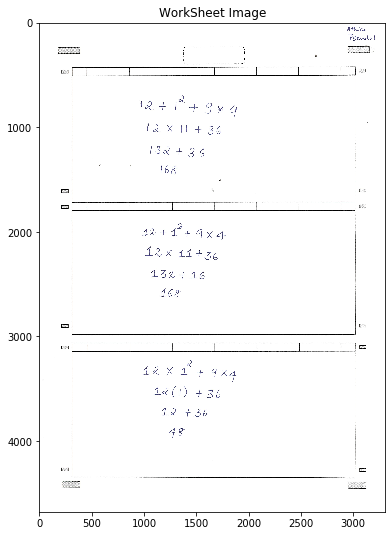

In [13]:
img = cv2.imread("data/image_3.jpg")
fig = plt.figure(figsize=(8,9))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('WorkSheet Image')

# Extracting WorkSpaces
## Logic Used:
### 1. Using area based rule to pinpoint the actual boxes inspite of many rectangles present in the worksheet

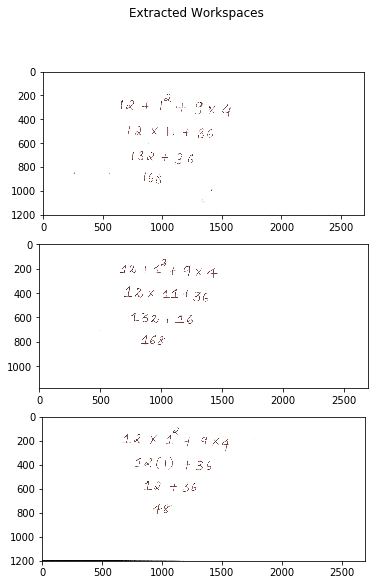

In [14]:
workspaces = extract_box(img)

# Line Detection

## Logic Used: For Line Localisation

![Array Differentiation](data\line_det.png)

Assumptions :
1) Sufficient gap between lines is required
2) There should be atleast some intersection between exponential character and line

Line Coordinates
186 443
417 596
626 813
816 947


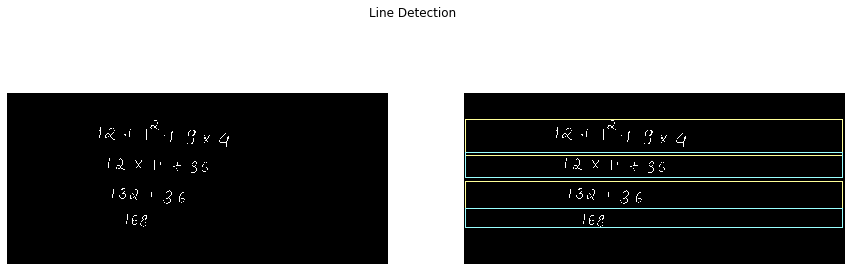

Lines in workspace-1 : 4
----------------------------------------------------------------------------------------------------
Line Coordinates
117 318
296 508
526 681
712 830


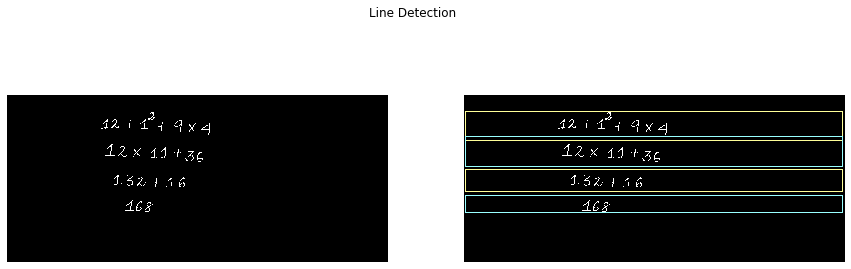

Lines in workspace-2 : 4
----------------------------------------------------------------------------------------------------
Line Coordinates
80 338
288 476
497 651
690 822


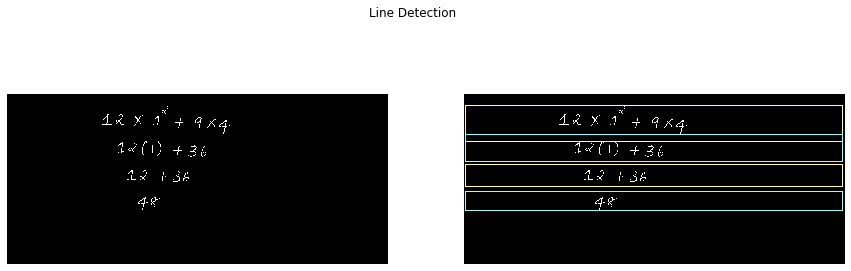

Lines in workspace-3 : 4
----------------------------------------------------------------------------------------------------


In [15]:
lines_all = []
df_lines = pd.DataFrame()

count = 0
for r,rect in enumerate(workspaces):
    box = img[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
    H,W = box.shape[:2]
    cleaned_orig,y1s,y2s = extract_line(box, show=True)
    x1s = [0]*len(y1s)
    x2s = [W]*len(y1s)
    
    if(len(y1s)-len(y2s) == 0):
        print('Lines in workspace-%d : %d' %(r+1, len(y1s)))
        print('-'*100)
    
    df = pd.DataFrame([y1s,y2s,x1s,x2s]).transpose()
    df.columns = ['y1','y2','x1','x2']
    df['box_num'] = r
    df_lines= pd.concat([df_lines, df])

    dict_clean_img.update({r:cleaned_orig})

df_lines['line_name'] = ['%d%d' %(df_lines.box_num.iloc[i],df_lines.index[i]) \
        for i in range(len(df_lines))]

# Text Segmentation
## Logic Used : 
### 1) Finding Disjoint Contours in image 2) Removing very small contours (Noises) based on threshold

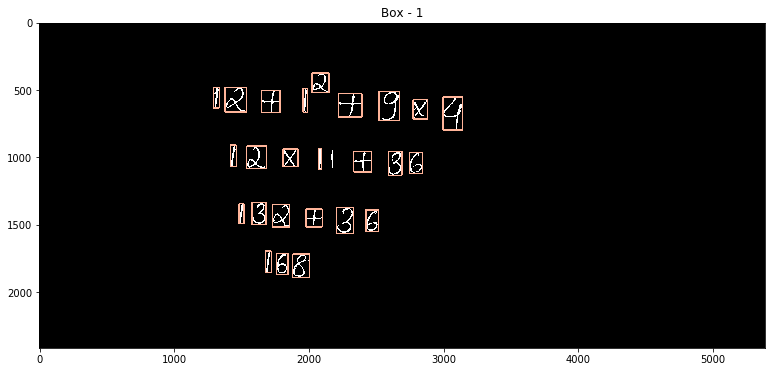

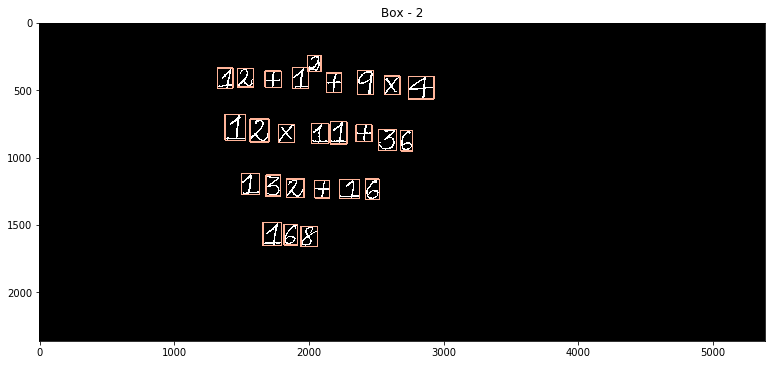

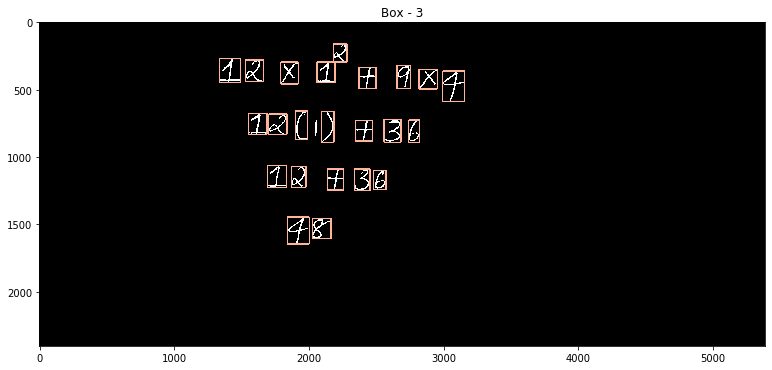

In [16]:
#df_chars contains locations of all characters along with box_num and line name
list_chars = list(df_lines.apply(lambda row: text_segment(row['y1'],row['y2'],row['x1'],row['x2'], row['box_num'],row['line_name'], show=False), axis=1))
df_chars = pd.DataFrame(list_chars)
df_chars.columns = ['box_num', 'line_name', 'char_df']

#Area based threshold for detecting and removing noises
char_area_list = []
df_chars['char_df'].apply(lambda d: char_area_list.append(list(d['area'])) )

gamma = 0.10
max_ar = max([max(i) for i in char_area_list])
ar_thresh = max_ar*gamma

#Keeping only those characters whose area of contours is above area threshold
df_chars['char_df'] = df_chars['char_df'].apply(lambda d: d[d.area > ar_thresh] )

#Plotting detected Characters

box_nums = df_chars.box_num.unique()
#fig3 = plt.figure(figsize=(7,9))
#fig3.suptitle('Characters Segmented')

for bn in box_nums:
    box_img = dict_clean_img[bn]
    
    box_img = cv2.cvtColor(box_img, cv2.COLOR_GRAY2BGR)
    
    df = df_chars[df_chars.box_num == bn]
    df['char_df'].apply(lambda d: d.apply(lambda c: cv2.rectangle(box_img, (c['X1'],c['Y1']),(c['X2'], c['Y2']),(153,180,255),3), axis=1 ) )

    scale_percent = 200 # percent of original size
    width = int(box_img.shape[1] * scale_percent / 100)
    height = int(box_img.shape[0] * scale_percent / 100)
    dim = (width, height)    
    box_img = cv2.resize(box_img, dim, interpolation = cv2.INTER_AREA)
#    ax = fig3.add_subplot(3,1,bn+1)
#    ax.axis('off')
#    ax.imshow(cv2.cvtColor(box_img, cv2.COLOR_BGR2RGB))
    plt.figure(figsize=(13,7))
    plt.title('Box - %d' %(bn+1) )
    plt.imshow(cv2.cvtColor(box_img, cv2.COLOR_BGR2RGB))
    